In [1]:
import numpy as np
import pandas as pd

from scipy import signal
from scipy import integrate
from scipy import fftpack

import matplotlib.pyplot as plt

import utils
import mac
import oma
import rfp

# plt.style.use('seaborn-pastel')

# 1) Simulación de edificio de excitado en la base

In [2]:
# Edificio de 4 pisos de 20 toneladas cada uno, con rigideces laterales de 57MN/m entre si
k = 57e6 # N/m
m = 20e3 # kg
k1, k2, k3 = (k,)*3
k4, k5 = (2*k,)*2
m1, m2, m3, m5 = (m,)*4
m4 = 0.0001*m # Punto intermedio de medicion

# Matrices de rigidez y de masa
K = np.array([[k1+k2, -k2, 0, 0, 0],
             [-k2, k2+k3, -k3, 0, 0],
             [0, -k3, k3+k4, -k4, 0],
             [0, 0, -k4, k4+k5, -k5],
             [0, 0, 0, -k5, k5]])

M = np.diag((m1, m2, m3, m4, m5))

print("K:")
utils.printMatrix(K)
print("M:")
utils.printMatrix(M)

K:
1.14E+08 -5.70E+07 0.00E+00 0.00E+00 0.00E+00 
-5.70E+07 1.14E+08 -5.70E+07 0.00E+00 0.00E+00 
0.00E+00 -5.70E+07 1.71E+08 -1.14E+08 0.00E+00 
0.00E+00 0.00E+00 -1.14E+08 2.28E+08 -1.14E+08 
0.00E+00 0.00E+00 0.00E+00 -1.14E+08 1.14E+08 
M:
2.00E+04 0.00E+00 0.00E+00 0.00E+00 0.00E+00 
0.00E+00 2.00E+04 0.00E+00 0.00E+00 0.00E+00 
0.00E+00 0.00E+00 2.00E+04 0.00E+00 0.00E+00 
0.00E+00 0.00E+00 0.00E+00 2.00E+00 0.00E+00 
0.00E+00 0.00E+00 0.00E+00 0.00E+00 2.00E+04 


In [3]:
# Edificio de 4 pisos de 20 toneladas cada uno, con rigideces laterales de 57MN/m entre si
n_pisos = 4
n_dof = 2*n_pisos

k_piso = 57e6 # N/m
m_piso = 20e3 # kg

k_dof = 2*k_piso
m_dof = m_piso*1E-4

k = k_dof * np.ones(n_dof)
m = np.tile(np.array([m_dof, m_piso]), n_pisos)

# Matrices de rigidez y de masa
K_diag = np.diag(k + np.concatenate([k[1:], [0]]))
K_supdiag = np.diag(-k[1:], k=1)
K_lowdiag = np.diag(-k[1:], k=-1)
K = K_diag + K_supdiag + K_lowdiag
M = np.diag(m)

print("K:")
utils.printMatrix(K)
print("M:")
utils.printMatrix(M)

K:
2.28E+08 -1.14E+08 0.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 
-1.14E+08 2.28E+08 -1.14E+08 0.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 
0.00E+00 -1.14E+08 2.28E+08 -1.14E+08 0.00E+00 0.00E+00 0.00E+00 0.00E+00 
0.00E+00 0.00E+00 -1.14E+08 2.28E+08 -1.14E+08 0.00E+00 0.00E+00 0.00E+00 
0.00E+00 0.00E+00 0.00E+00 -1.14E+08 2.28E+08 -1.14E+08 0.00E+00 0.00E+00 
0.00E+00 0.00E+00 0.00E+00 0.00E+00 -1.14E+08 2.28E+08 -1.14E+08 0.00E+00 
0.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 -1.14E+08 2.28E+08 -1.14E+08 
0.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 -1.14E+08 1.14E+08 
M:
2.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 
0.00E+00 2.00E+04 0.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 
0.00E+00 0.00E+00 2.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 0.00E+00 
0.00E+00 0.00E+00 0.00E+00 2.00E+04 0.00E+00 0.00E+00 0.00E+00 0.00E+00 
0.00E+00 0.00E+00 0.00E+00 0.00E+00 2.00E+00 0.00E+00 0.00E+00 0.00E+00 
0.00E+00 0.00E+00 0.00E+00 0.00

In [4]:
# Resolución por autovectores y autovalores
A = np.linalg.inv(M)@K
lambdas, eigenvecs = np.linalg.eig(A)
idx = lambdas.argsort()  
lambdas = lambdas[idx]
eigenvecs = eigenvecs[:,idx]

In [6]:
# Frecuencias modales
w_modes = np.sqrt(lambdas)
f_modes = w_modes/2/np.pi
print(('f = {}').format(np.round(f_modes,3)))

f = [   2.951    8.496   13.017   15.968 1699.312 1699.331 1699.36  1699.385]


In [7]:
# Matriz de masas modales
M_modal = np.transpose(eigenvecs)@M@eigenvecs
M_modal[M_modal<1e-3] = np.nan
print("Masas modales:")
utils.printMatrix(M_modal)

Masas modales:
1.14E+04 NAN NAN NAN NAN NAN NAN NAN 
NAN 1.26E+04 NAN NAN NAN NAN NAN NAN 
NAN NAN 1.51E+04 NAN NAN NAN NAN NAN 
NAN NAN NAN 1.83E+04 NAN NAN NAN NAN 
NAN NAN NAN NAN 2.00E+00 NAN NAN NAN 
NAN NAN NAN NAN NAN 2.00E+00 NAN NAN 
NAN NAN NAN NAN NAN NAN 2.00E+00 NAN 
NAN NAN NAN NAN NAN NAN NAN 2.00E+00 


In [8]:
# Tomo primeros N modos
total_modes = 4

Max value off diagonal: 0.013


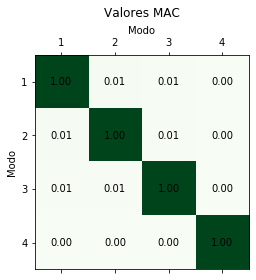

In [9]:
# MAC teórico
MAC_theo = mac.get_MAC_matrix(eigenvecs[: , :total_modes], eigenvecs[: , :total_modes])
mac.plot_MAC(MAC_theo, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_theo)))

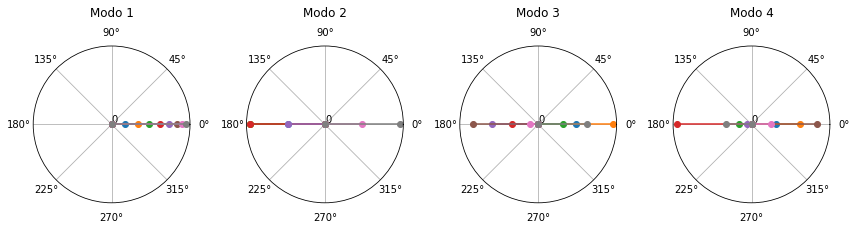

In [10]:
utils.plot_modes_complexity(eigenvecs[: , :total_modes])

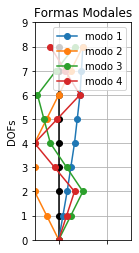

In [11]:
utils.plot_column_modes(eigenvecs[: , :total_modes])

## 1.1) Simulación de aceleración con perfil de ruido blanco

In [12]:
# Aceleración maxima en funcion del tiempo
def max_accel(t,t_end):
    a = 0.5*(1-np.cos(2*np.pi*t/t_end))
    return a

In [13]:
# Simulación de aceleracion en forma de ruido blanco bajo la curva de aceleracion maxima
t_end = 3000
delta_t = 1/119
t = np.linspace(0, t_end, int(t_end/delta_t))

R = 0.1*np.random.normal(size=len(t)) # Vector de ruido gaussiano
R_mean = np.mean(R)

Ug_time = (R - R_mean)*max_accel(t, t_end) # Aceleración escalada con ruido
max_accel_vec = max_accel(t, t_end) # Vector con aceleraciones puras

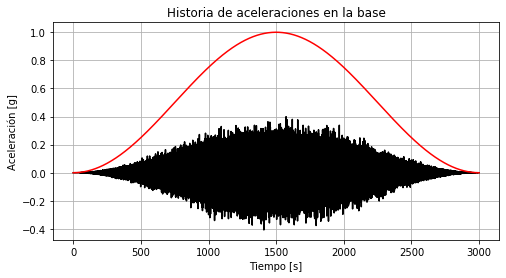

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, Ug_time, color='k', marker='')
ax.plot(t, max_accel_vec, color='r')
plt.title('Historia de aceleraciones en la base')
plt.xlabel('Tiempo [s]')
plt.ylabel('Aceleración [g]')
ax.grid(True, markevery=1)

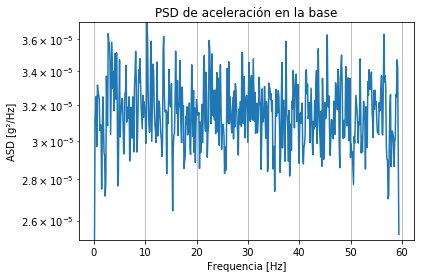

In [15]:
# PSD de aceleraciones en la base
nperseg = 1024
freq, Ug_psd = signal.welch(Ug_time, 
                      fs=1./(delta_t), # sample rate
                      window='hamming', # apply a Hanning window before taking the DFT
                      nperseg=nperseg, # compute periodograms of 256-long segments of x
                      noverlap=nperseg//2,
                      detrend='constant',
                      return_onesided=False) #'constant') # detrend x by subtracting the mean)

plt.figure()
plt.semilogy(freq[1:len(Ug_psd)//2], Ug_psd[1:len(Ug_psd)//2])
plt.title('PSD de aceleración en la base')
plt.ylim([np.min(Ug_psd[1:]), np.max(Ug_psd[1:])])
plt.xlabel('Frequencia [Hz]')
plt.ylabel('ASD [g²/Hz]')
plt.grid()
plt.show()

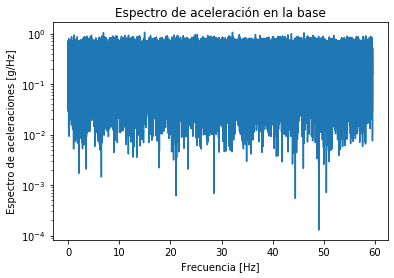

In [16]:
# Transformada de Fourier de aceleraciones en la base
Ug_fft = np.fft.fft(Ug_time)
Ug_fft_freq = np.fft.fftfreq(t.shape[-1], d=delta_t)

plt.figure()
plt.semilogy(Ug_fft_freq[:len(Ug_fft_freq)//2], abs(Ug_fft[:len(Ug_fft_freq)//2]))
plt.title('Espectro de aceleración en la base')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Espectro de aceleraciones [g/Hz]')
plt.show()

## 1.2) Simulación de respuesta dinámica del edificio a ruido blanco su base

In [17]:
total_dofs = eigenvecs.shape[0]
mode_num = np.arange(total_modes)
modeshapes = eigenvecs[:, :total_modes]
w_modes = w_modes[:total_modes]
f_modes = f_modes[:total_modes]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:total_dofs]

In [18]:
xi = 0.025 # fracción de amortiguamiento crítico
Xi = xi*np.ones(modeshapes.shape[1])
r = np.ones(total_dofs) # vector logico de desplazamientos respecto de la base
print('xi = {}'.format(Xi))
print('r = {}^T'.format(r))

xi = [0.025 0.025 0.025 0.025]
r = [1. 1. 1. 1. 1. 1. 1. 1.]^T


La solucion del espectro de desplazamientos para cada modo es
<br/>
<center> $Y(\omega) = \frac{\frac{\iota}{m_i} U_g(\omega)}{\omega_i^2 - \omega^2 + 2i \xi_i \omega_i \omega}$ </center>
<br/>
con
<center> $\iota = \Phi^T M r$. </center>
<br/>
Y la aceleración es
<center> $\ddot{Y}(\omega) = \omega^2 Y(\omega)$ </center>

In [19]:
U_g = np.copy(Ug_fft)
w = 2*np.pi*Ug_fft_freq
f = w/2/np.pi

In [20]:
I = np.transpose(eigenvecs)@M@r
m_modal = M_modal.diagonal() 
Y = np.zeros((len(w), total_modes), dtype=complex)
ddotY = np.copy(Y) 
for mode in range(total_modes):
    C = I[mode] / (m_modal[mode]*(w_modes[mode]**2 - w**2 + 2*1j*Xi[mode]*w_modes[mode]*w))
    Y[:,mode] = C*Ug_fft
    ddotY[:,mode] = -(w**2) * Y[:, mode]

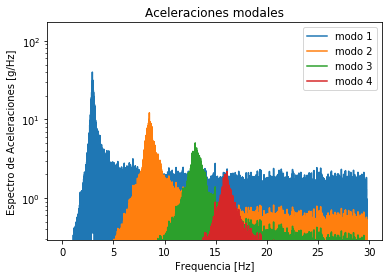

40.06441803700226


In [21]:
plt.figure()
lgnd  = ['modo {}'.format(mode+1) for mode in range(total_modes)]
plt.semilogy(f[:len(f)//4], abs(ddotY[:len(f)//4]))
plt.title('Aceleraciones modales')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Espectro de Aceleraciones [g/Hz]')
plt.ylim([abs(ddotY[len(f)//4, 0]), None])
plt.legend(lgnd, loc='upper right')
plt.show()
print(np.max(abs(ddotY)))

### 1.2.1) Respuesta en cada piso

In [22]:
# Espectro de respuesta en frecuencia
X = np.copy(Y)
X = (modeshapes @ Y.T).T # Desplazamientos en los grados de libertad
ddotX = -(w**2 * X.T).T # Aceleraciones

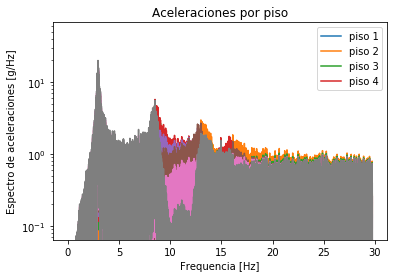

In [23]:
plt.figure()
lgnd  = ['piso {}'.format(mode+1) for mode in range(total_modes)]
plt.semilogy(f[:len(f)//4], abs(ddotX[:len(f)//4,:]))
plt.title('Aceleraciones por piso')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Espectro de aceleraciones [g/Hz]')
plt.ylim([abs(ddotX[len(f)//4, 0]), None])
plt.legend(lgnd, loc='upper right')
plt.show()

# 2. Operational Modal Analysis

In [24]:
# Respuesta en el tiempo
ddotX_time = fftpack.ifft(ddotX, axis=0) # Obtengo respuestas en el tiempo mediante transformada inversa

# Matriz de densidades espectrales cruzadas de la respuesta.
csd_nperseg = 1024
S_xx = np.zeros((csd_nperseg, total_dofs, total_dofs), dtype=complex)
for dof1 in range(total_dofs):
    for dof2 in range(total_dofs):
        f_S, S_xx[:, dof1, dof2] = signal.csd(ddotX_time[:, dof1], ddotX_time[:, dof2],
                                               fs=1./(delta_t),
                                               window='hanning',
                                               nperseg=csd_nperseg,
                                               detrend='constant',
                                               axis=0,
                                               return_onesided=False)

## 2.2) Frequency Domain Decomposition (FDD)

In [25]:
# Extraigo frecuencias y formas de modo por SVD
u_fdd, s_fdd, vh_fdd = np.linalg.svd(S_xx)
    
# Maximos del primer valor singular
mode_ind_fdd = np.array([m for m in signal.argrelmax(s_fdd[:len(f_S)//4, 0], order=12)]).flatten()

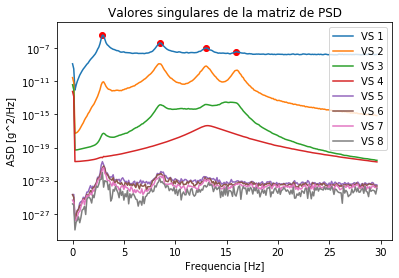

In [26]:
plt.semilogy(f_S[:len(f_S)//4], s_fdd[:len(f_S)//4, :])
# plt.ylim([s[len(f_S)//4, 0], None])
plt.scatter(f_S[mode_ind_fdd[:4]],
            abs(s_fdd[mode_ind_fdd[:4], 0]),
            color='r')
plt.title('Valores singulares de la matriz de PSD')
plt.ylabel('ASD [g^2/Hz]')
plt.xlabel('Frequencia [Hz]')
lgnd  = ['VS {}'.format(col+1) for col in range(s_fdd.shape[1])]
plt.legend(lgnd, loc='upper right')
plt.show()

## 2.4) Curve-fit Frequency Domain Decomposition (CFDD)

### 2.4.1) Estimación mediante cuadrado de la FRF

(3.967872095643997e-09, 5.364253752398156e-05)

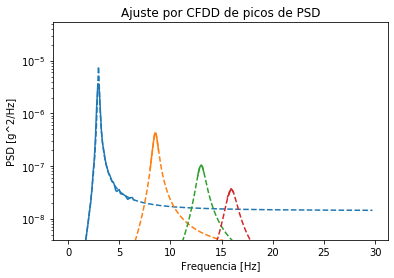

In [27]:
mac_th = 0.9
freq = f_S
f_cfdd = np.zeros(total_modes)
xi_cfdd = np.zeros(total_modes)

freq_hat = np.linspace(0, f[len(f)//2-1], 4000)
psd_hat = np.zeros((freq_hat.size, total_modes))

for mode in range(total_modes):
    peak_idx = mode_ind_fdd[mode]
    efdd_idxes = oma.get_efdd_segment(u_fdd, peak_idx, mac_th)
    f_cfdd[mode], xi_cfdd[mode], psd_hat[:, mode] = oma.curve_fit_psd_peak(freq, s_fdd[:, 0], efdd_idxes, freq_hat)
    
    plt.semilogy(freq[efdd_idxes[0]:efdd_idxes[1]],
                 abs(s_fdd[efdd_idxes[0]:efdd_idxes[1], 0]),
                 color=colors[mode])
    plt.semilogy(freq_hat[:freq_hat.size//2],
                 abs(psd_hat[:freq_hat.size//2, mode]),
                 color=colors[mode],
                 linestyle='--')

plt.title('Ajuste por CFDD de picos de PSD')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('PSD [g^2/Hz]')
plt.ylim([abs(psd_hat[len(freq_hat)//4, 1]), None])

In [28]:
err_f_cfdd = (f_cfdd - f_modes)/f_modes*100

data = np.vstack((mode_num, f_modes, f_cfdd)).T
headers = ['Modo', 'Teoría [Hz]', 'CFDD [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

,Modo,Teoría [Hz],CFDD [Hz]
0,0,2.95,2.96
1,1,8.50,8.51
2,2,13.02,12.98
3,3,15.97,15.92


In [29]:
data = np.vstack((mode_num, Xi, xi_cfdd)).T
headers = ['Modo', 'Teoría', 'CFDD']
utils.print_modes_dataframe(data=data, headers=headers, decimals=3)

,Modo,Teoría,CFDD
0,0,0.025,0.021
1,1,0.025,0.032
2,2,0.025,0.034
3,3,0.025,0.034


# 3) Experimental Modal Analysis (EMA)

## 3.1) Estimadores de FRF: H1 y H2

<br/>
<center> $H(\omega) = \frac{X(\omega)}{F(\omega)}$ </center>
<br/>
<center> $H_1(\omega) = \frac{S_{XF}(\omega)}{S_{FF}(\omega)}$ </center>
<br/>
<center> $H_2(\omega) = \frac{S_{XX}(\omega)}{S_{XF}(\omega)}$ </center>
<br/>

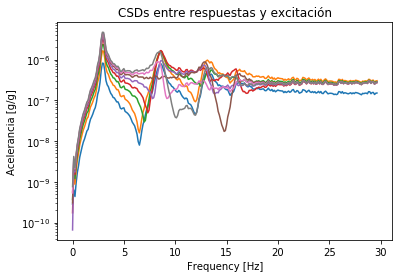

In [30]:
# Densidades espectrales cruzadas entre respuestas e input.
csd_nperseg = 1024
S_xf = np.zeros((csd_nperseg, total_dofs), dtype=complex)
for dof in range(total_dofs):
        f_S, S_xf[:, dof] = signal.csd(ddotX_time[:, dof], Ug_time,
                                               fs=1./(delta_t),
                                               window='hanning',
                                               nperseg=csd_nperseg,
                                               detrend='constant',
                                               axis=0,
                                               return_onesided=False)

plt.semilogy(f_S[:len(f_S)//4], np.abs(S_xf[:len(f_S)//4]))
plt.title('CSDs entre respuestas y excitación')
plt.ylabel('Acelerancia [g/g]')
plt.xlabel('Frequency [Hz]')
plt.show()

In [31]:
H1 = np.zeros((S_xf.shape[0], total_dofs), dtype=complex)
for dof in range(total_dofs):
    H1[:, dof] = S_xf[:, dof] / Ug_psd

max_ind_H1 = np.array([m for m in signal.argrelmax(np.abs(H1[:len(f_S)//4, 0]), order=10)]).flatten()
print('Frecuencias de pico para H1 = {} Hz'.format(np.round(f_S[max_ind_H1[:4]], 2)))

H2 = np.zeros((S_xf.shape[0], total_dofs), dtype=complex)
for dof in range(total_dofs):
    H2[:, dof] = S_xx[:, dof, dof] / S_xf[:, dof]
max_ind_H2 = np.array([m for m in signal.argrelmax(np.abs(H2[:len(f_S)//4, 3]), order=10)]).flatten()
print('Frecuencias de pico para H2 = {} Hz'.format(np.round(f_S[max_ind_H2[:4]], 2)))

Frecuencias de pico para H1 = [ 2.91  8.48 13.13 16.27] Hz
Frecuencias de pico para H2 = [ 2.91  8.48 12.78 15.8 ] Hz


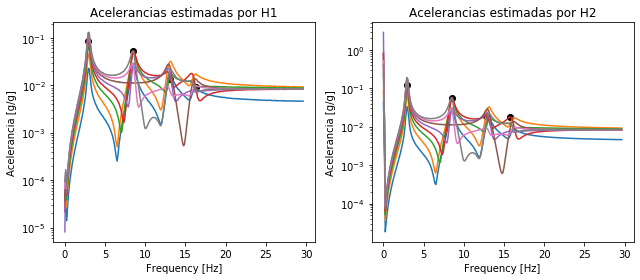

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax.flat[0].semilogy(f_S[:len(f_S)//4], np.abs(H1[:len(f_S)//4, :]))
ax.flat[0].scatter(f_S[max_ind_H1], np.abs(np.abs(H1[max_ind_H1,3])), color='k')
ax.flat[1].semilogy(f_S[:len(f_S)//4], np.abs(H2[:len(f_S)//4,:]))
ax.flat[1].scatter(f_S[max_ind_H2], np.abs(H2[max_ind_H2,3]), color='k')
for k in range(len(ax.flat)):
    ax.flat[k].set_title('Acelerancias estimadas por H{}'.format(k+1))
    ax.flat[k].set_ylabel('Acelerancia [g/g]')
    ax.flat[k].set_xlabel('Frequency [Hz]')

fig.tight_layout()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


(2.7, 7)

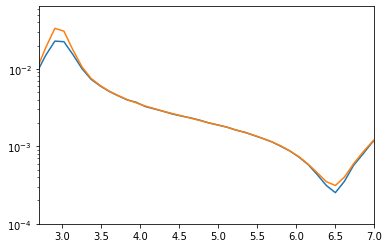

In [33]:
plt.semilogy(f_S[:len(f_S)//4], np.abs(H1[:len(f_S)//4, 0]))
plt.semilogy(f_S[:len(f_S)//4], np.abs(H2[:len(f_S)//4, 0]))
plt.ylim([10E-5, 0])
plt.xlim([2.7, 7])

## 3.2) Rational Fraction Polynomial (RFP)

In [34]:
# Conversión de acelerancia a receptancia(FRF) diviendo por el cuadrado de las frecuencias angulares
dof = 2
w_S = 2*np.pi*f_S[1:len(f_S)//2]
H_frf = H2[1:len(f_S)//2, dof] - 1

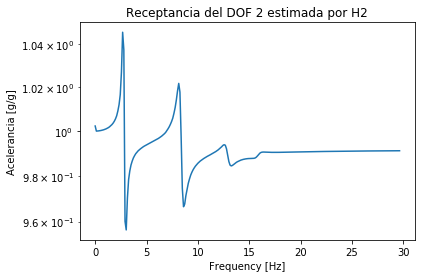

In [35]:
plt.semilogy(f_S[:len(f_S)//4], np.abs(H_frf[:len(f_S)//4]))
plt.title('Receptancia del DOF {} estimada por H2'.format(dof))
plt.ylabel('Acelerancia [g/g]')
plt.xlabel('Frequency [Hz]')
plt.show()

In [36]:
mode_ind_H_frf = np.array([m for m in signal.argrelmax(np.abs(H_frf), order=10)]).flatten()
print('Frecuencias de picos = {} Hz'.format(np.round(f_S[mode_ind_H_frf], 2)))

Frecuencias de picos = [ 2.67  8.13 12.55 16.39] Hz


In [37]:
idx = np.linspace(90, 160, 61, dtype=int)
omega = w_S[idx]
f_omega = omega/2/np.pi
frf = H_frf[idx]

modal_params, alpha = rfp.rfp(frf, omega, 3)

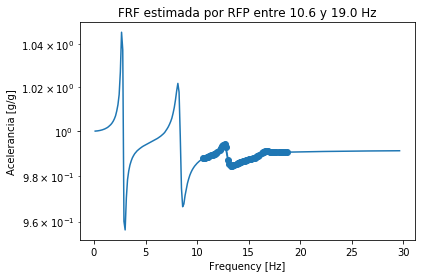

In [38]:
plt.semilogy(f_S[1:len(f_S)//4], np.abs(H_frf[1:len(f_S)//4]), color='tab:blue')
plt.semilogy(f_omega, np.abs(alpha), color='tab:blue', marker='o')
plt.title('FRF estimada por RFP entre {} y {} Hz'.format(
            np.round(f_omega[0],1),
            np.round(f_omega[-1]),1))
plt.ylabel('Acelerancia [g/g]')
plt.xlabel('Frequency [Hz]')
plt.show()

In [39]:
freq_n = modal_params[0]
xi_n = abs(modal_params[1])
print('Freqs = {} Hz'.format(np.round(freq_n, 2)))
print('Damps = {}'.format(np.round(xi_n, 3)))

Freqs = [12.88 16.42 22.8 ] Hz
Damps = [0.026 0.043 1.   ]


## 3.3) Global Rational Fraction Polynomial (GRFP)

In [40]:
idx = np.linspace(20, 80, 61, dtype=int)
omega = w_S[idx]
f_omega = omega/2/np.pi
frf = np.zeros_like(H2[idx, :], dtype=complex)
for dof in range(total_dofs):
    frf[:, dof] = H2[idx, dof] - 1

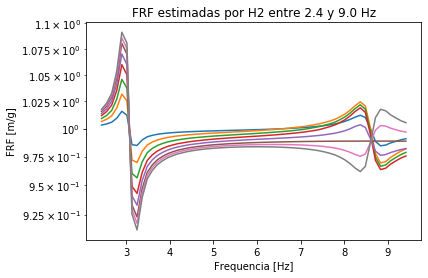

In [41]:
plt.title('FRF estimadas por H2 entre {} y {} Hz'.format(
            np.round(f_omega[0],1),
            np.round(f_omega[-1]),1))
plt.xlabel('Frequencia [Hz]')
plt.ylabel('FRF [m/g]')
plt.semilogy(f_omega, np.abs(frf))
plt.show()

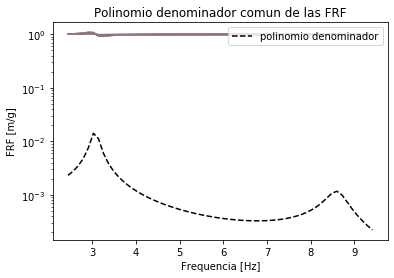

In [42]:
# Obtencion del polinomio denominador
denominator, denominator_coeff = rfp.grfp_denominator(frf, omega, 3)

plt.title('Polinomio denominador comun de las FRF')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('FRF [m/g]')
plt.semilogy(f_omega, np.abs(frf))
plt.semilogy(f_omega, np.abs(1/denominator), color='k', linestyle='--', label='polinomio denominador')
plt.legend(loc='upper right')
plt.show()

Frequencias: [3.06 8.61] Hz
Amortiguamientos: [0.027 0.025]


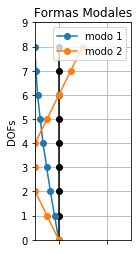

In [43]:
# Obtencion de los parametros modales de cada FRF
frf_estimates, modal_params = rfp.grfp_parameters(frf, omega, denominator, denominator_coeff, 3)
f_grfp, xi_grfp, modal_mag_n, modal_ang_n = modal_params
modes_grfp = (modal_mag_n*np.exp(1j*modal_ang_n)).T

print('Frequencias: {} Hz'.format(np.round(f_grfp, 2)))
print('Amortiguamientos: {}'.format(np.round(xi_grfp, 3)))
utils.plot_column_modes(modes_grfp)
plt.show()

In [44]:
top = len(f_grfp)
data = np.vstack((mode_num[:top], f_modes[:top], f_cfdd[:top], f_grfp)).T
headers = ['Modo', 'Teoría [Hz]', 'CFDD [Hz]', 'GRFP [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

,Modo,Teoría [Hz],CFDD [Hz],GRFP [Hz]
0,0,2.95,2.96,3.06
1,1,8.50,8.51,8.61


Max value off diagonal: 0.013


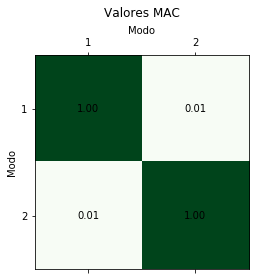

In [45]:
MAC_grfp = mac.get_MAC_matrix(modeshapes[:,:top], modes_grfp)
mac.plot_MAC(MAC_grfp, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_grfp)))

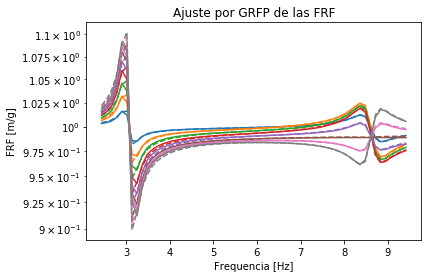

In [46]:
# Grafico de estimaciones de FRF
plt.title('Ajuste por GRFP de las FRF')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('FRF [m/g]')
for dof in range(frf.shape[1]):
    plt.semilogy(f_omega, np.abs(frf[:, dof]), color=colors[dof])
    plt.semilogy(f_omega, np.abs(frf_estimates[:, dof]), color=colors[dof], linestyle='--')
plt.show()